## Tectonics and Landscape Evolution Class part 1



#### We are going to use our field work measurements to create our model from the Teton Fault

In [9]:
import numpy as np
curr_time = np.array([4])
throw_time = np.array([0, 8, 10])
throw_rate = np.array([0., 0.5, 0.2])
test_interp = np.interp(curr_time, throw_time, throw_rate)
print(test_interp)

[0.25]


In [13]:
#Importing required functions 

import pandas as pd
from landlab import RasterModelGrid, imshow_grid
from landlab.components import StreamPowerEroder, LinearDiffuser, FlowAccumulator,NormalFault
import numpy as np
import matplotlib.pyplot as plt
from FieldWork_class import FieldWork

The average strike is 10.0
The average dip is 58.904761904761905
Your area has 15000 km x 11250 km, the grid has 225.0 rows and 500.0 columns


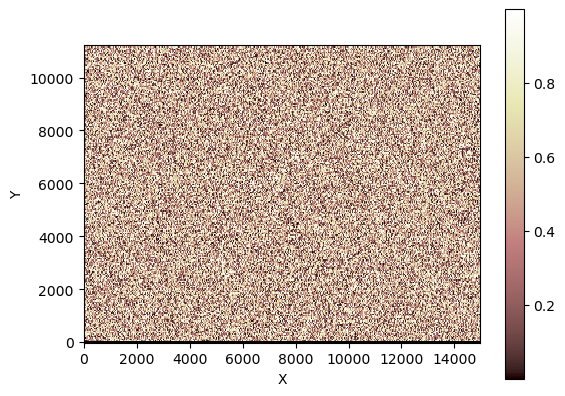

In [16]:
#Import you field work data
data = pd.read_csv('field_work_teton_park.csv')
data

#Calculate parameters for your model
fw = FieldWork(data)
result = fw.calculate_dip_strike()

#Set the size of your area
x_size = 15000 # in meters
y_size  = 11250 # in meters
dx = 30 #cell resolution in x (meters)
dy = 50 #cell resolution in y (meters)

rows,cols = fw.calculate_grid_size(x_size,y_size,dx,dy) 

#create basin_mg
basin_mg = RasterModelGrid((rows,cols),xy_spacing=(30,50)) #rows = y, cols = x

# Add elevation field
np.random.seed(35)
z = basin_mg.add_zeros('topographic__elevation', at='node')
z += np.random.rand(z.size)

# Set boundary conditions to match Teton

basin_mg.set_closed_boundaries_at_grid_edges(False,True,False,True) #top,left,bottom,right
imshow_grid(basin_mg, 'topographic__elevation')
# plt.show()




In [23]:
## Initialise the landscape and parameters

# Dictionary for parameter values
params  = {'stream_power': {'K_sp': 5E-6, 
                        'n_sp': 1, 
                        'm_sp': 0.45}, 
                        'diffuser': {'D_diff': 0.001}}

K_sp = params['stream_power']['K_sp']
m_sp = params['stream_power']['m_sp']
n_sp = params['stream_power']['n_sp']

## Forward model evolution

n_steps = 1001
dt = 1000  # timestep in years

U = np.ones(basin_mg.number_of_nodes)
uplift_rate = 0.0005 #in meters/years
U = U*uplift_rate

fa = FlowAccumulator(basin_mg, flow_director='D8')
ld = LinearDiffuser(basin_mg, linear_diffusivity=params['diffuser']['D_diff'])
sp = StreamPowerEroder(basin_mg, K_sp=K_sp, m_sp=m_sp, n_sp=n_sp)

uplift_per_steps = dt * U

#### For class purpose we are gonna load the steady state model from a txt-file

In [24]:
from time import time

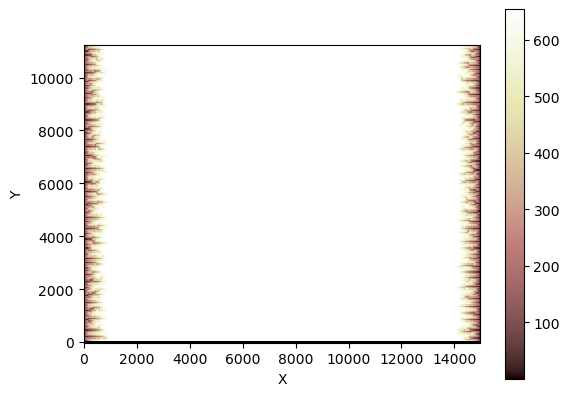

0


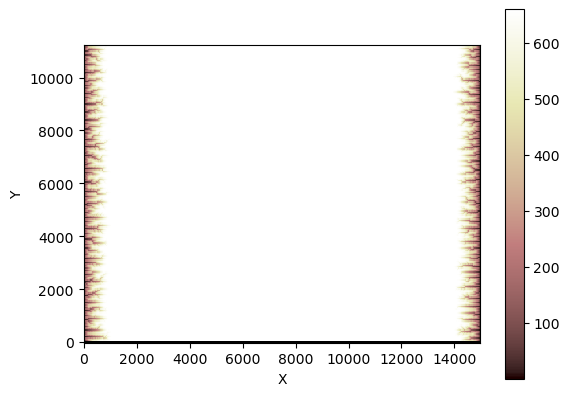

10


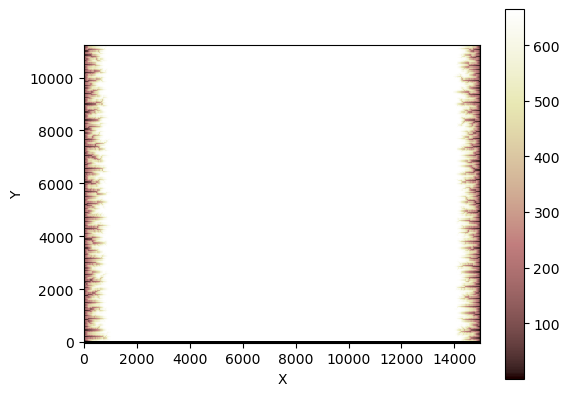

20


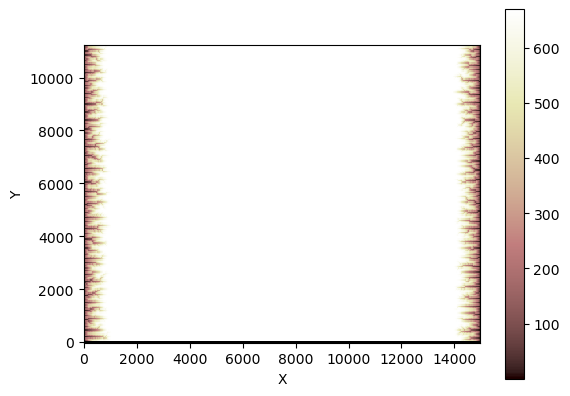

30


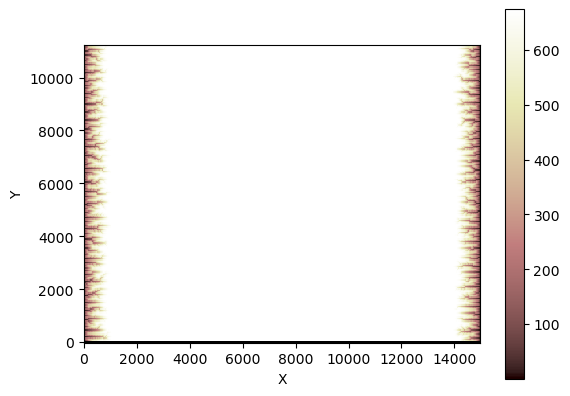

40


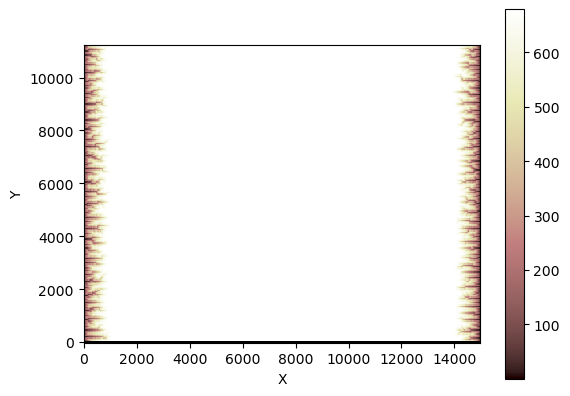

50


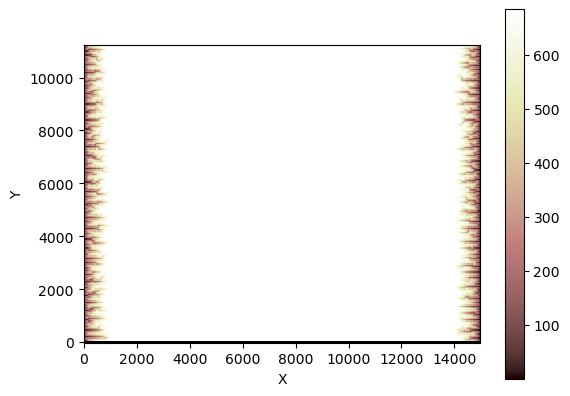

60


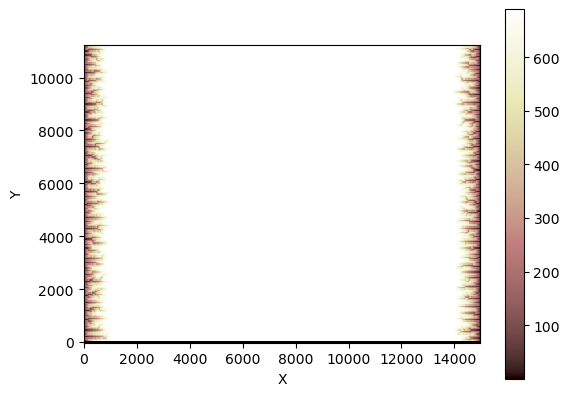

70


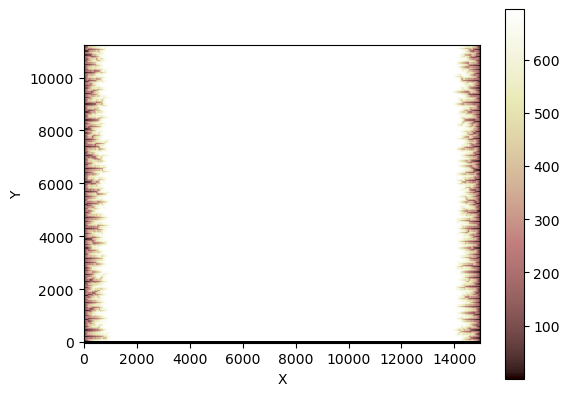

80


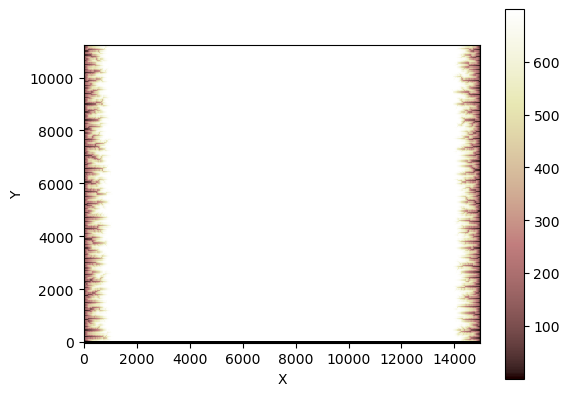

90


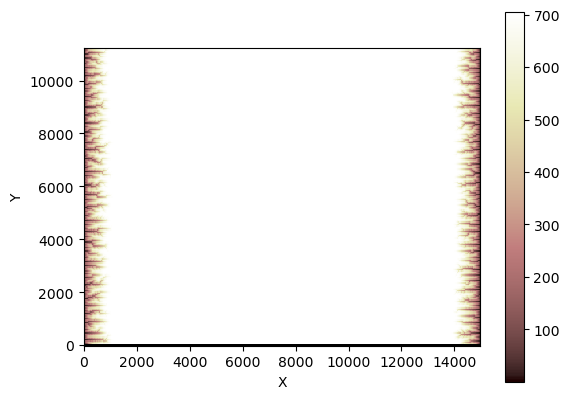

100


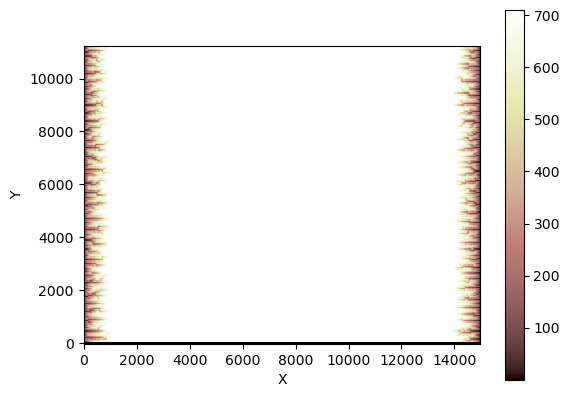

110


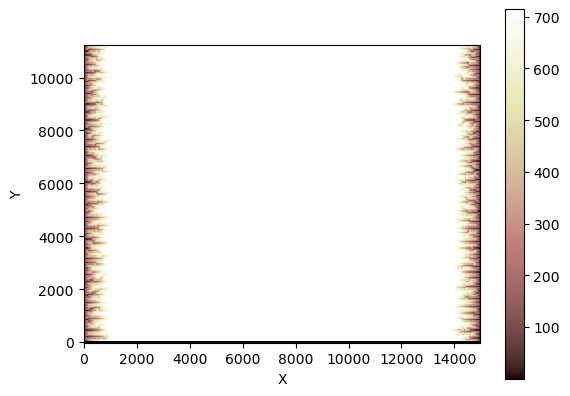

120


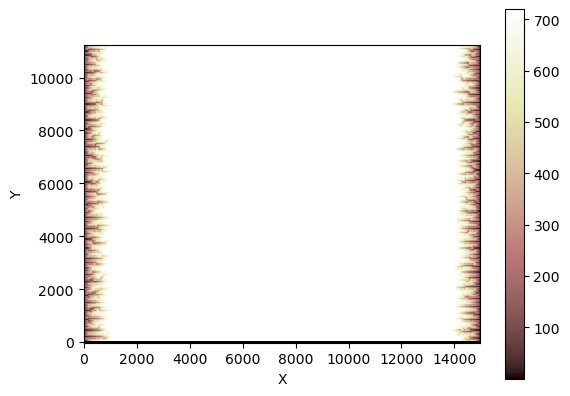

130


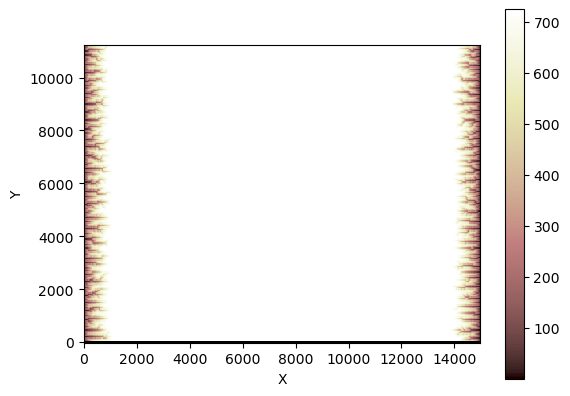

140


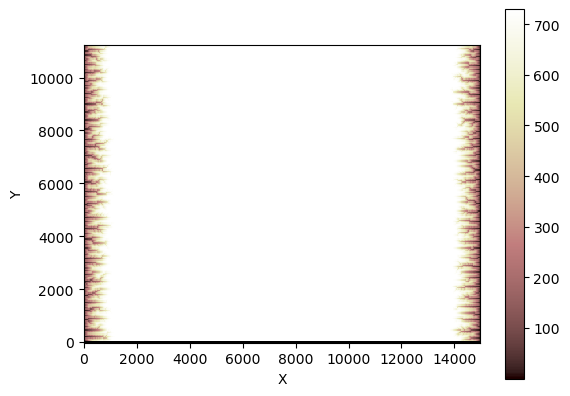

150


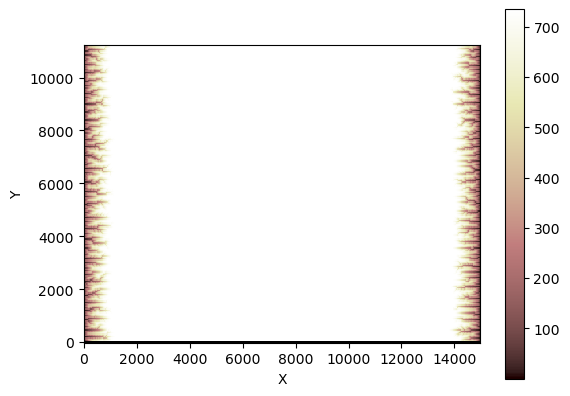

160


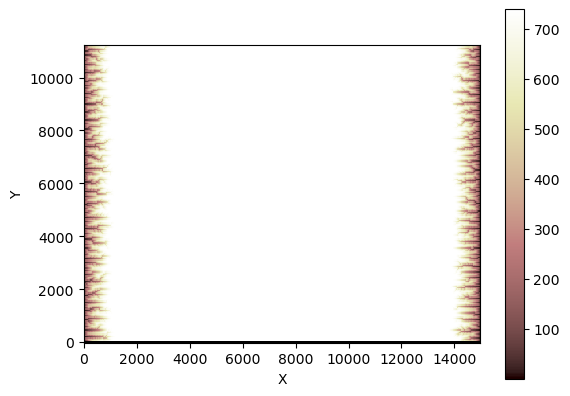

170


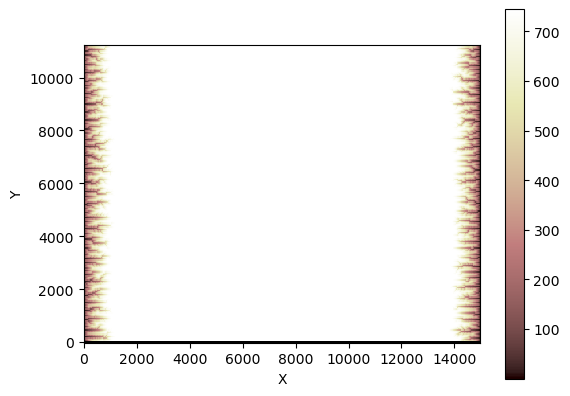

180


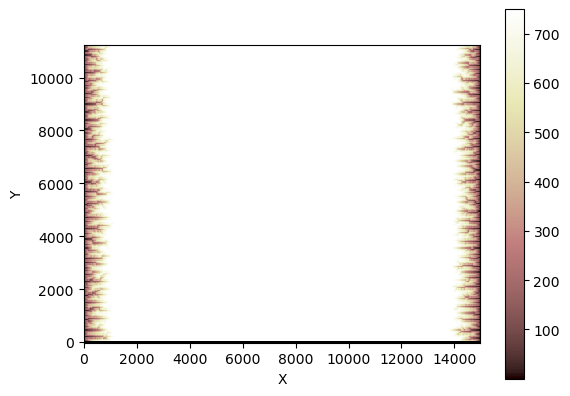

190


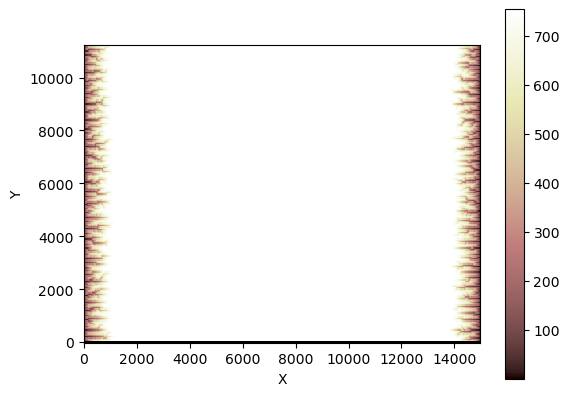

200


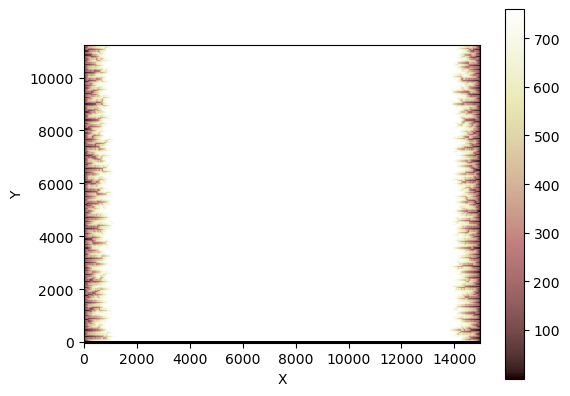

210


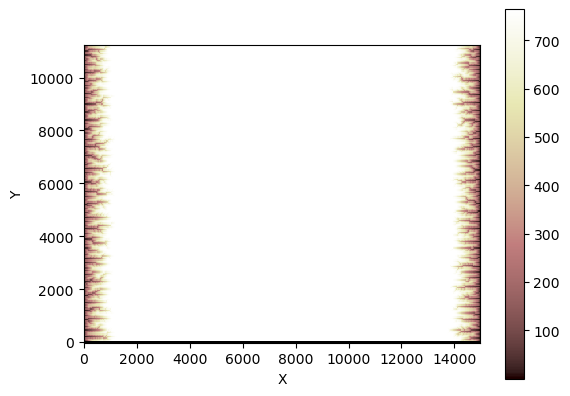

220


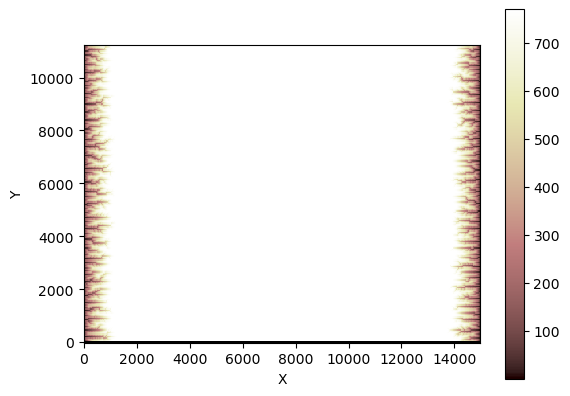

230


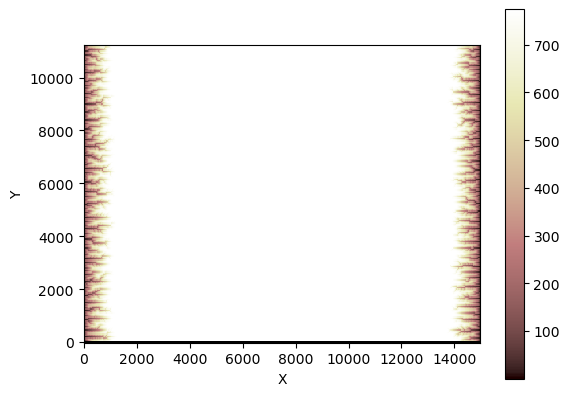

240


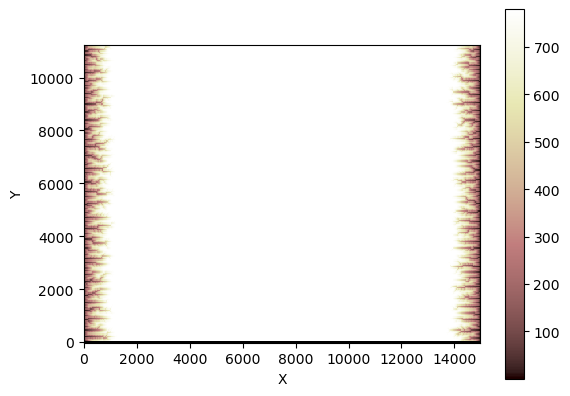

250


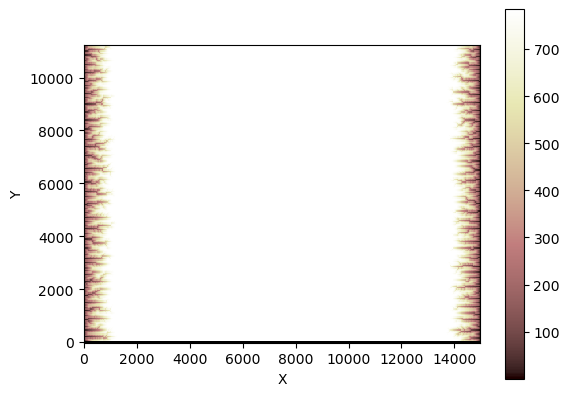

260


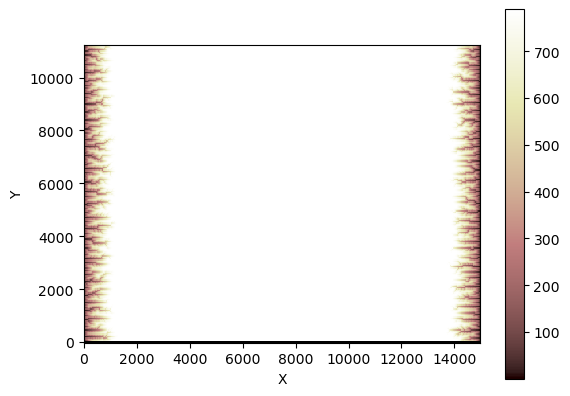

270


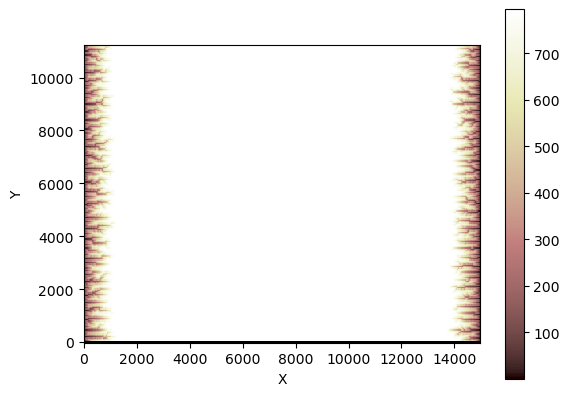

280


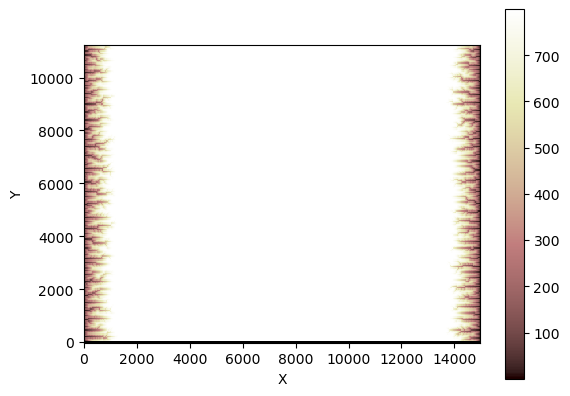

290


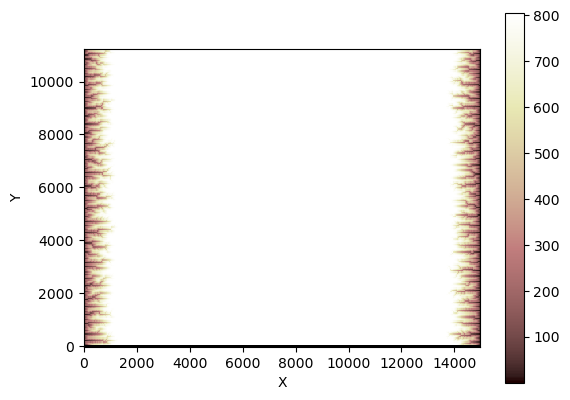

300


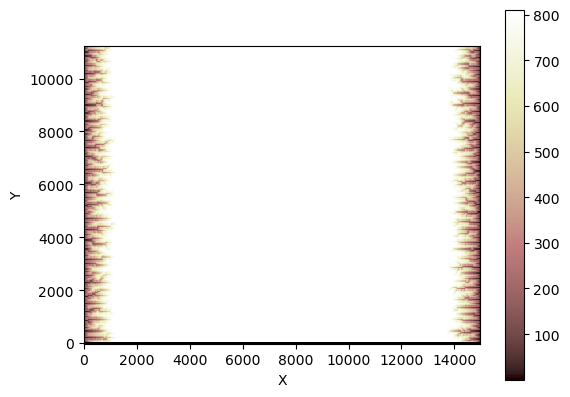

310


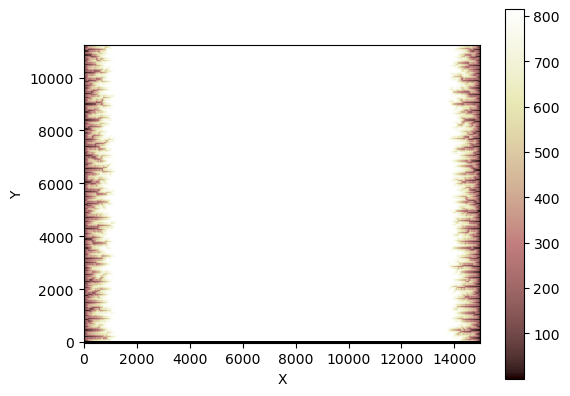

320


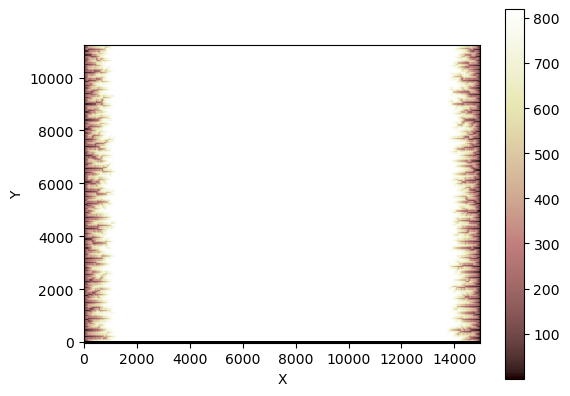

330


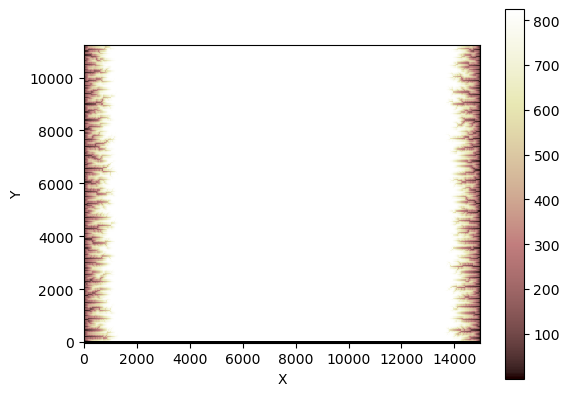

340


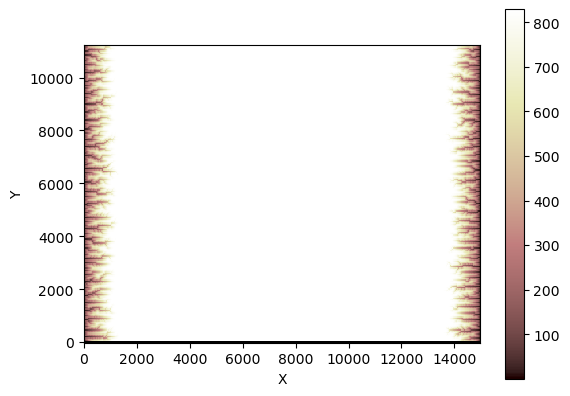

350


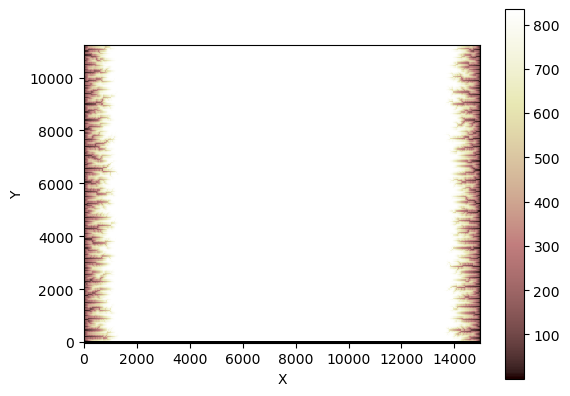

360


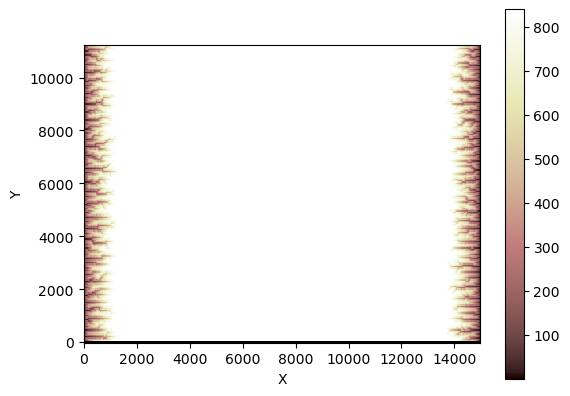

370


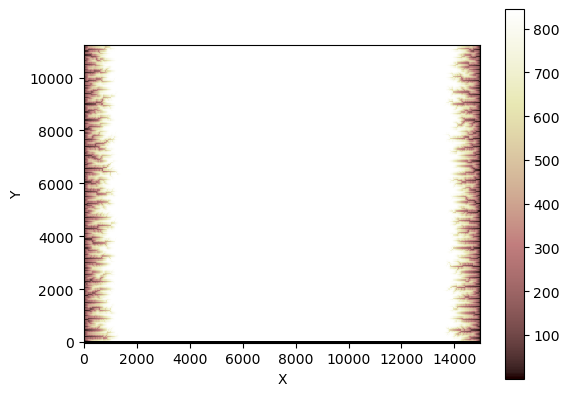

380


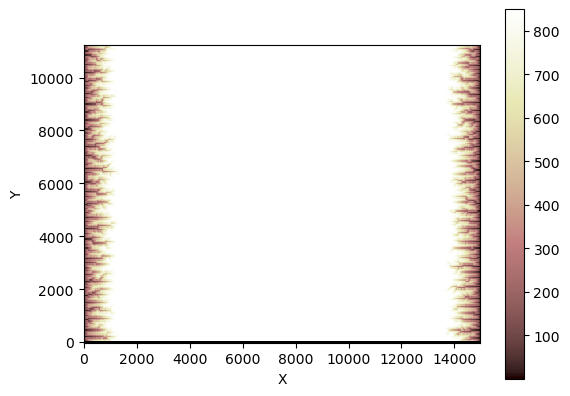

390


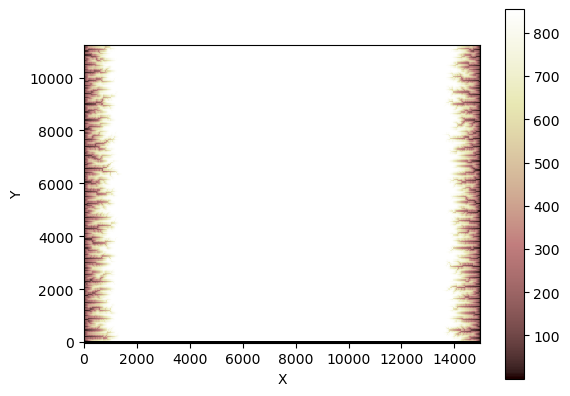

400


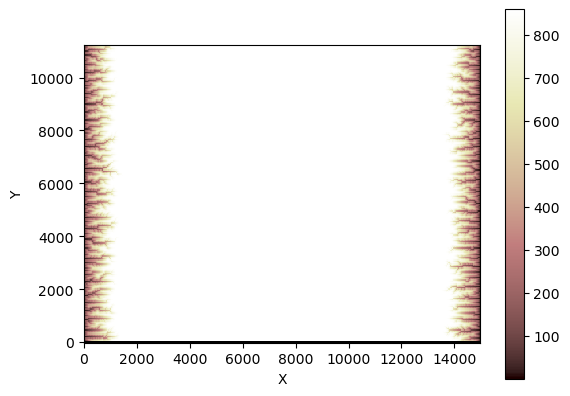

410


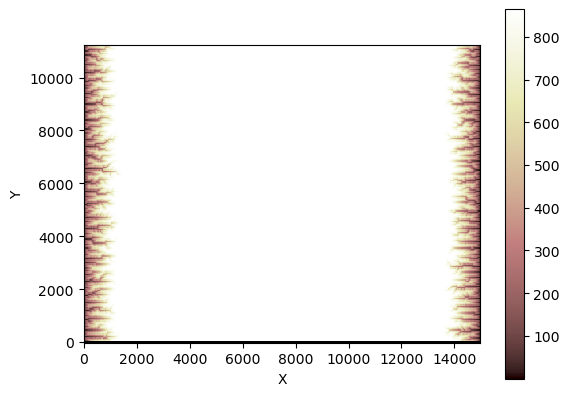

420


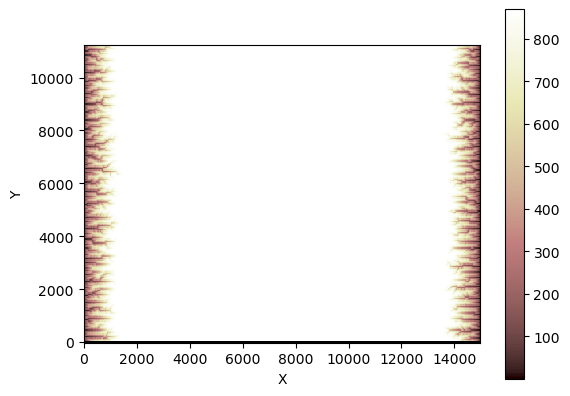

430


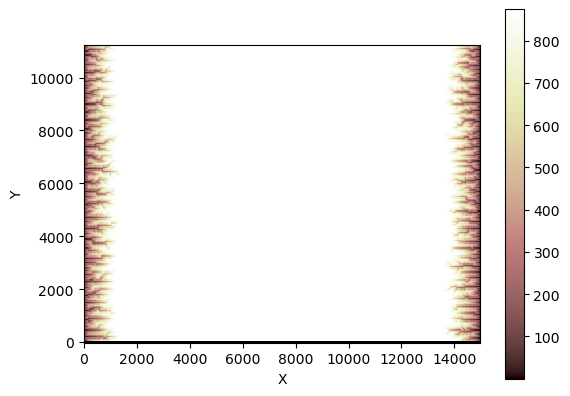

440


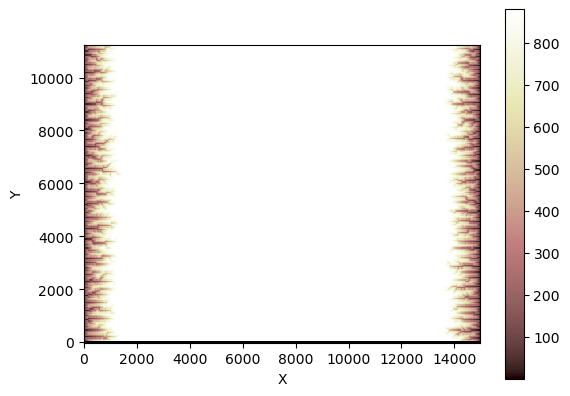

450


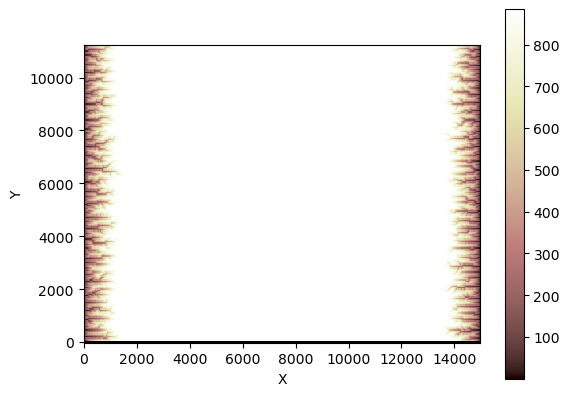

460


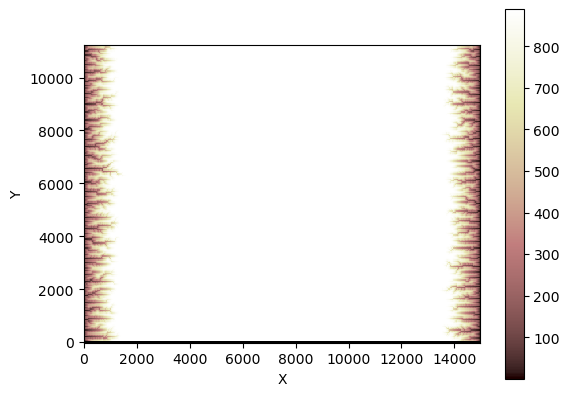

470


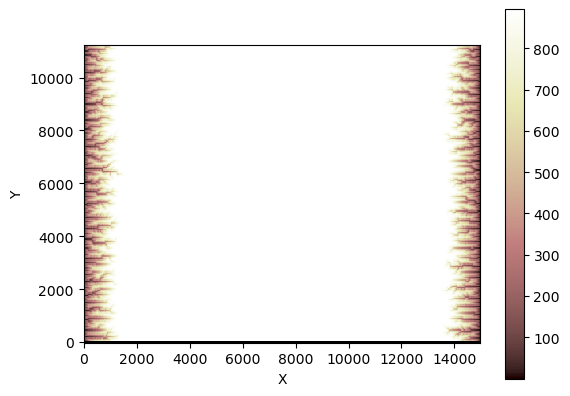

480


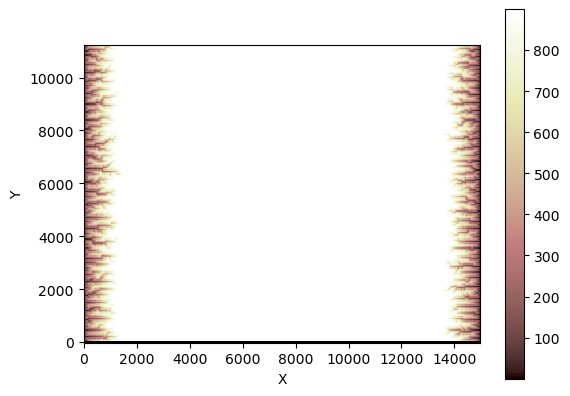

490


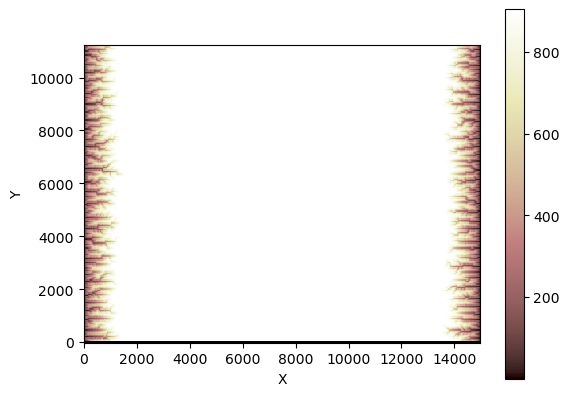

500


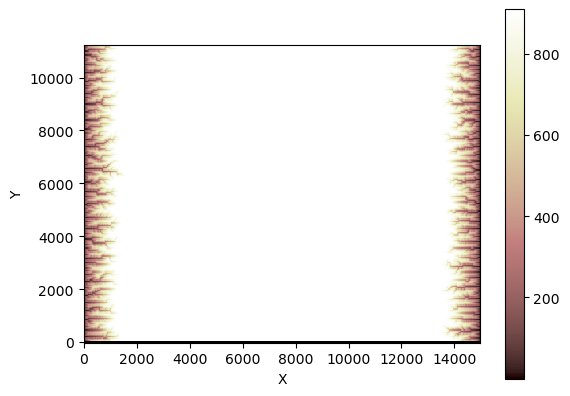

510


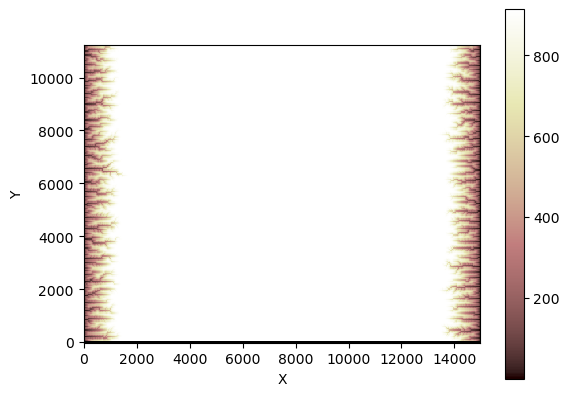

520


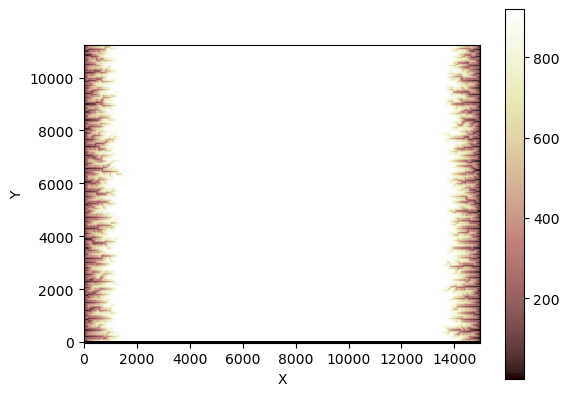

530


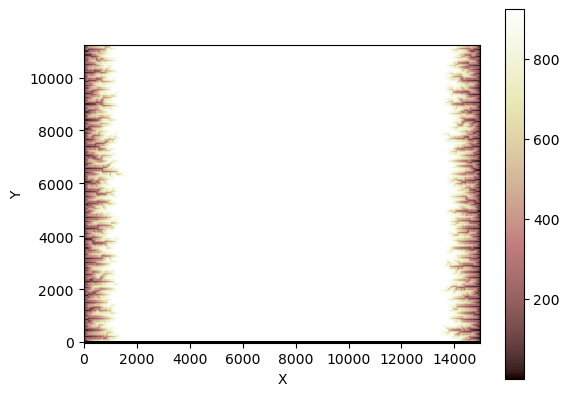

540


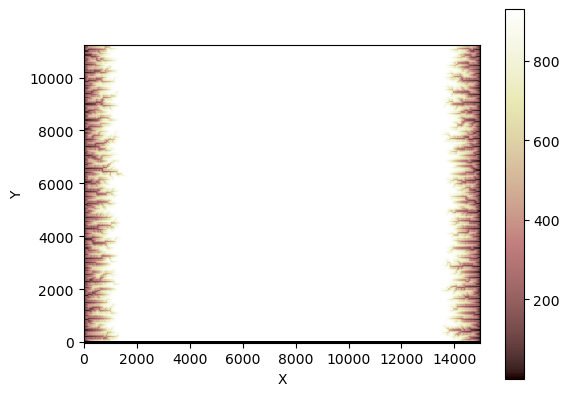

550


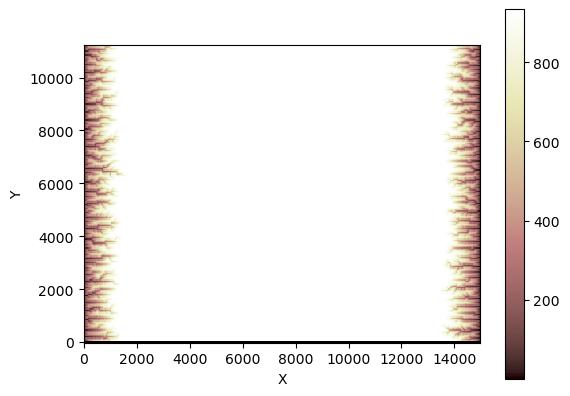

560


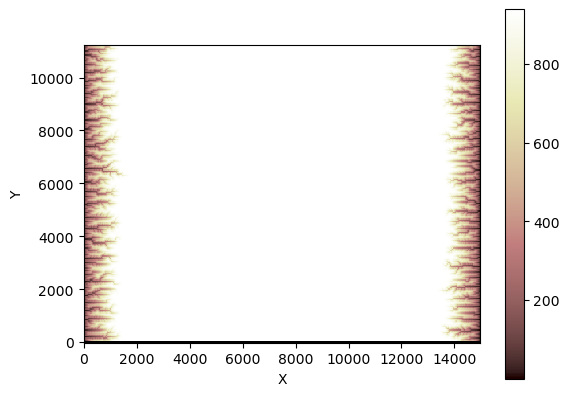

570


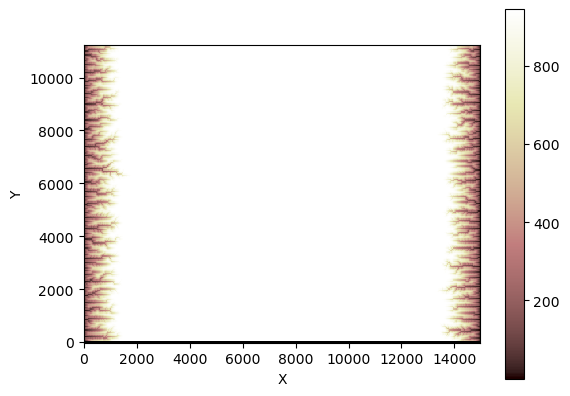

580


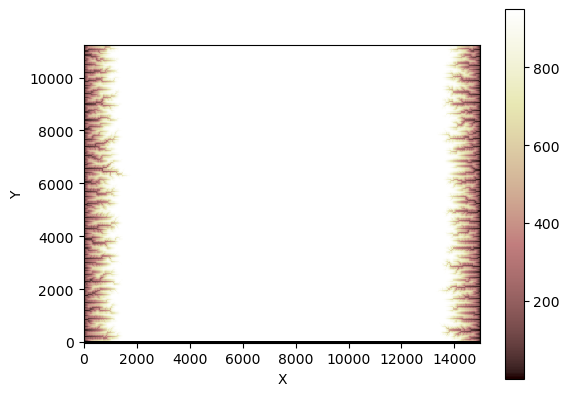

590


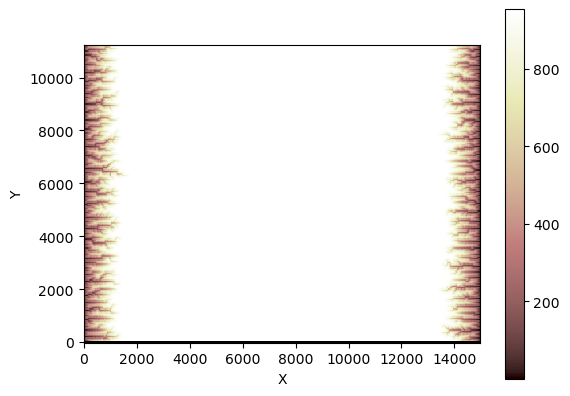

600


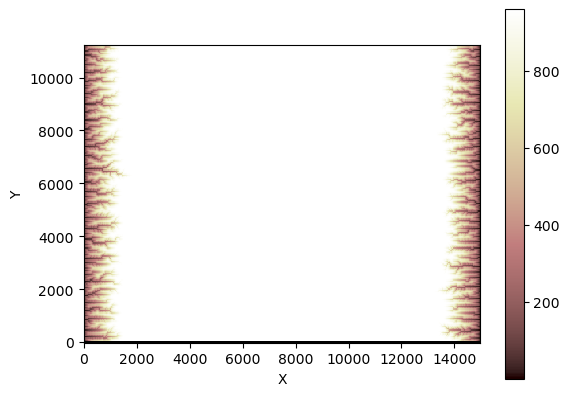

610


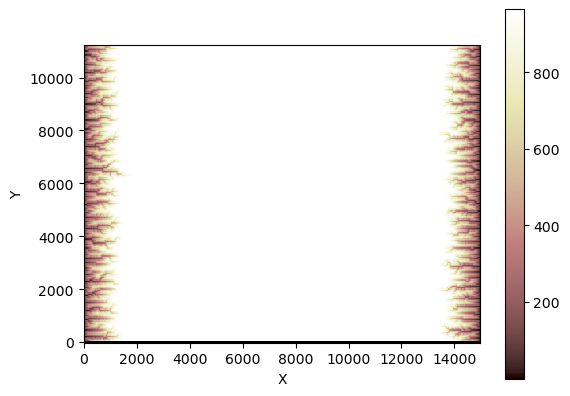

620


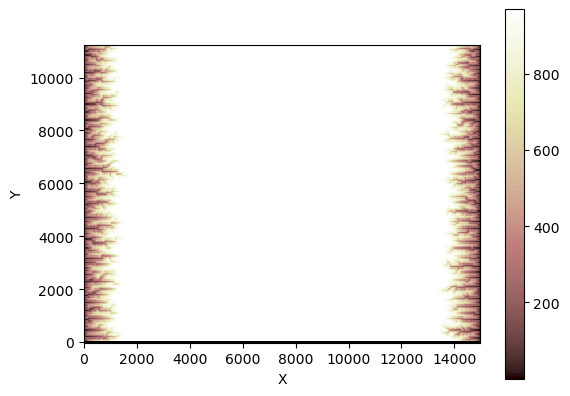

630


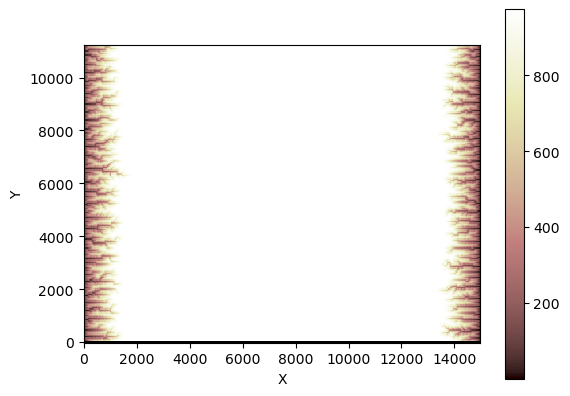

640


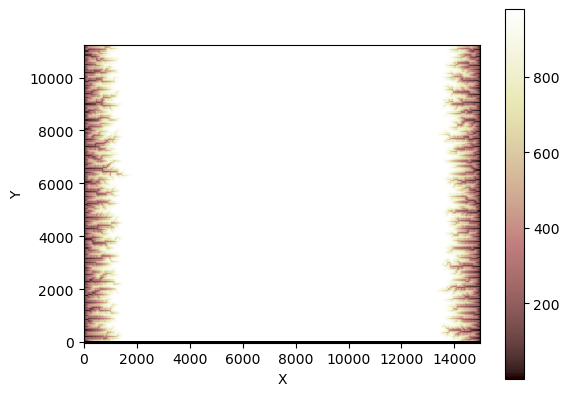

650


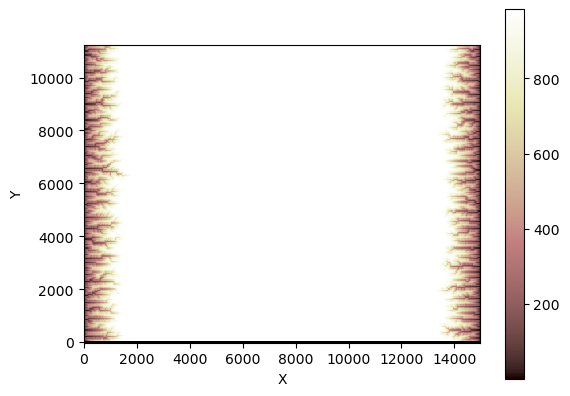

660


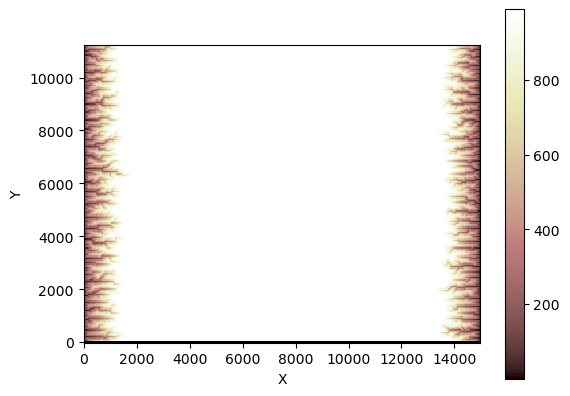

670


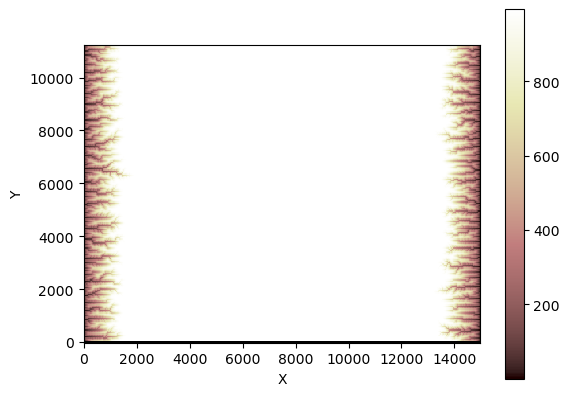

680


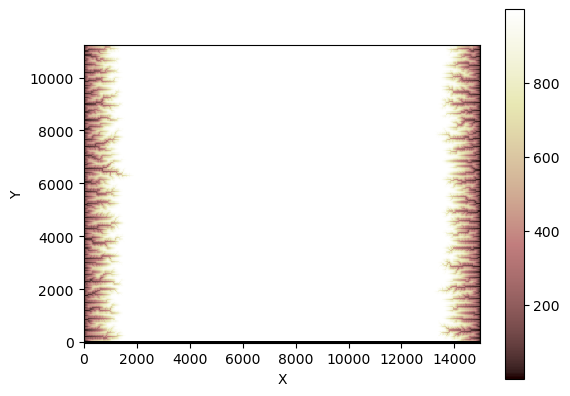

690


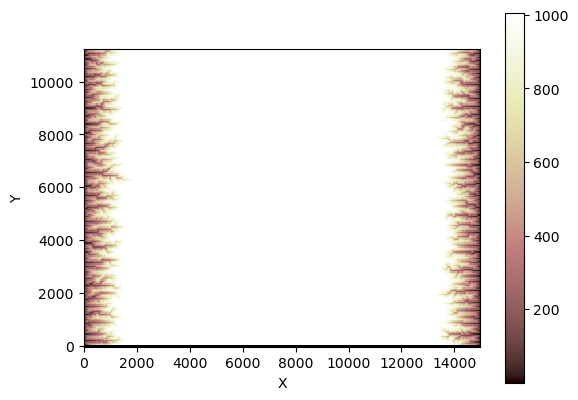

700


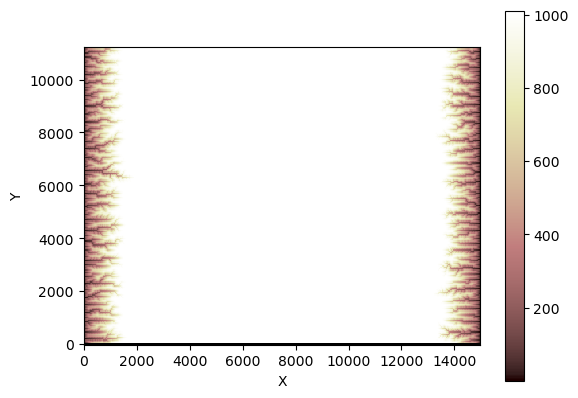

710


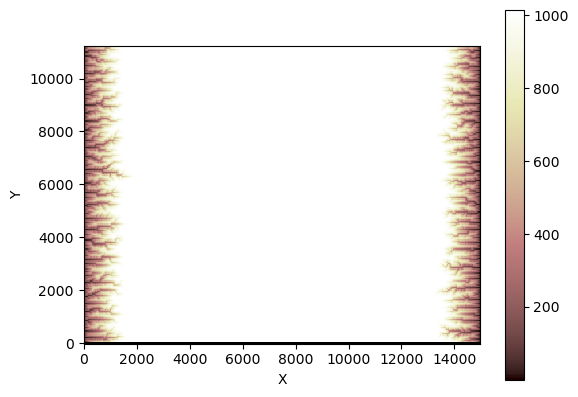

720


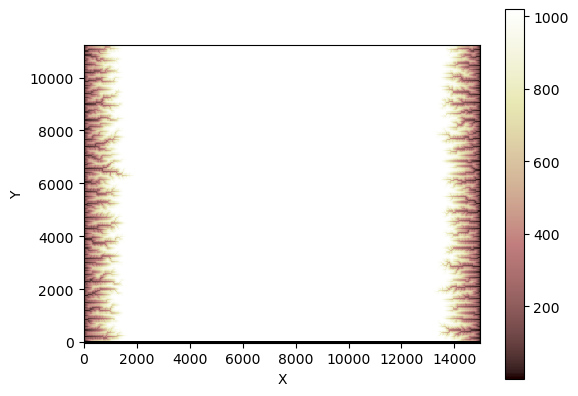

730


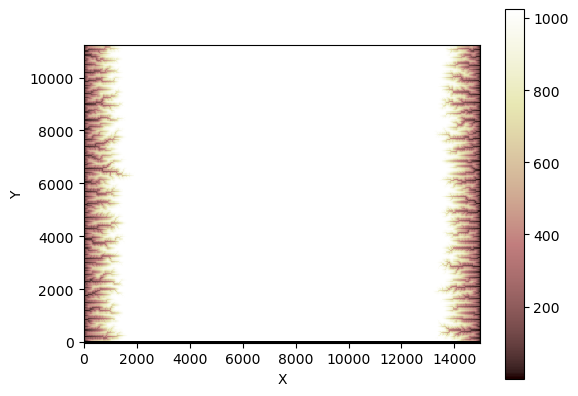

740


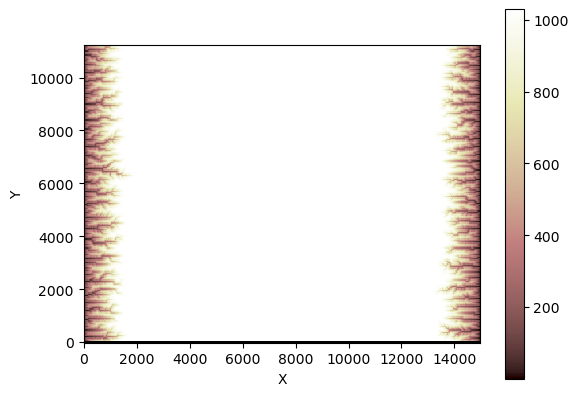

750


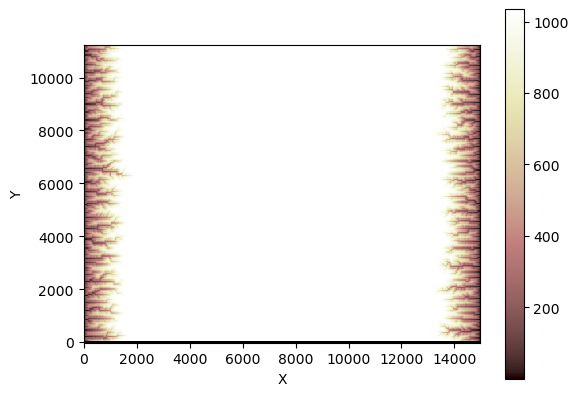

760


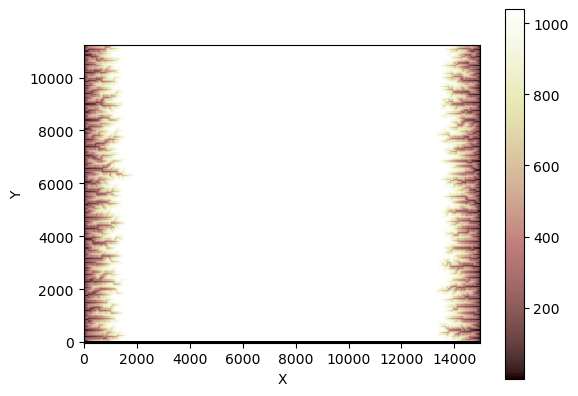

770


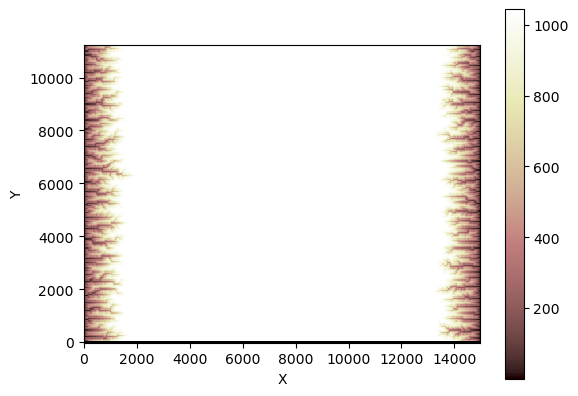

780


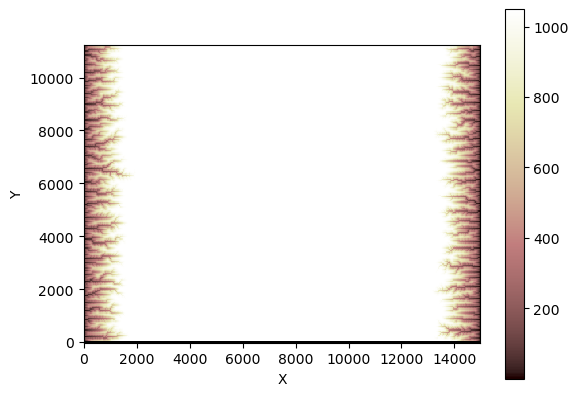

790


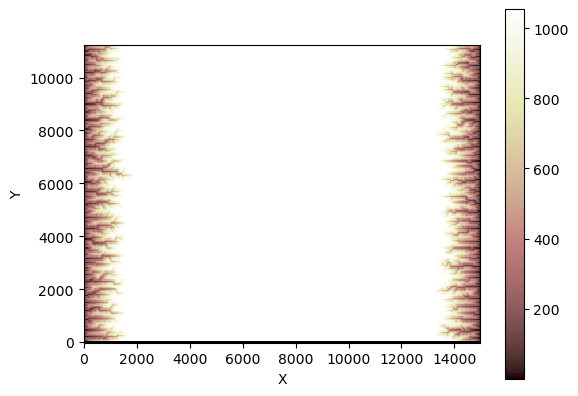

800


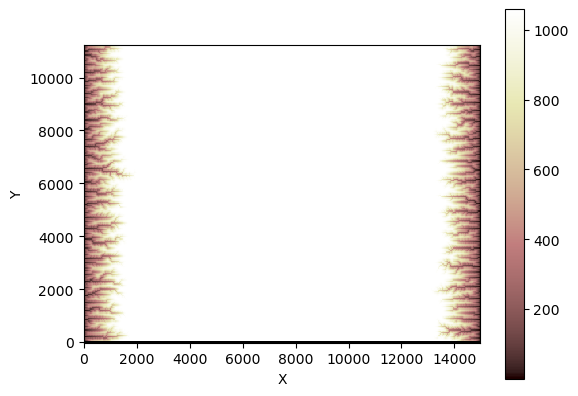

810


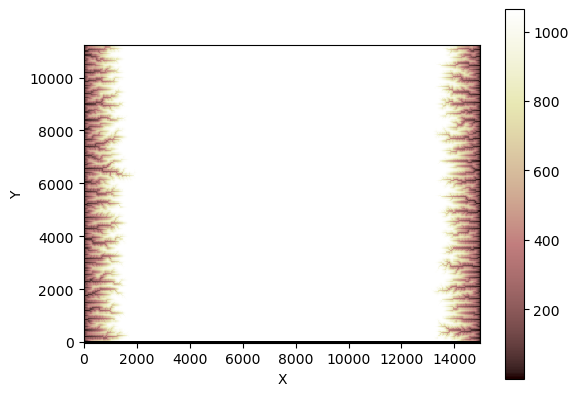

820


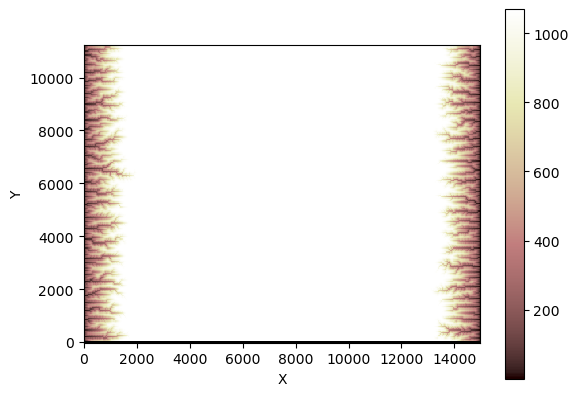

830


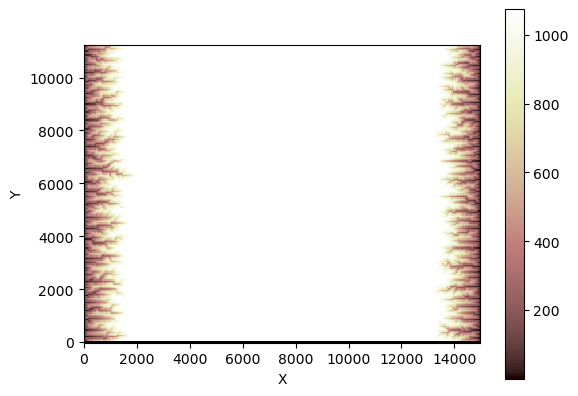

840


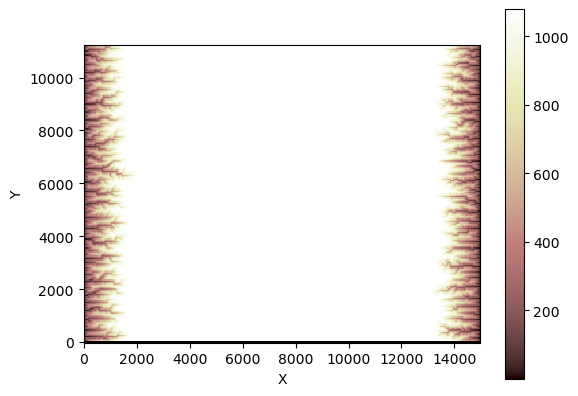

850


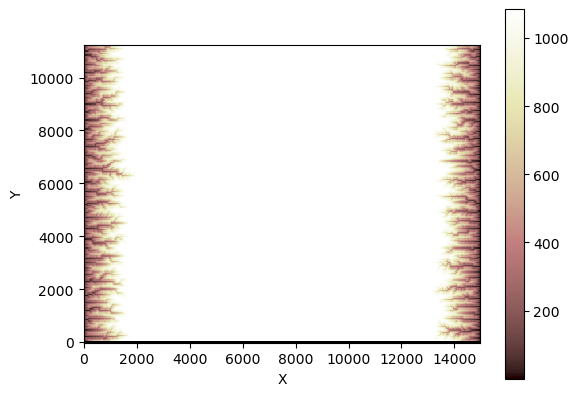

860


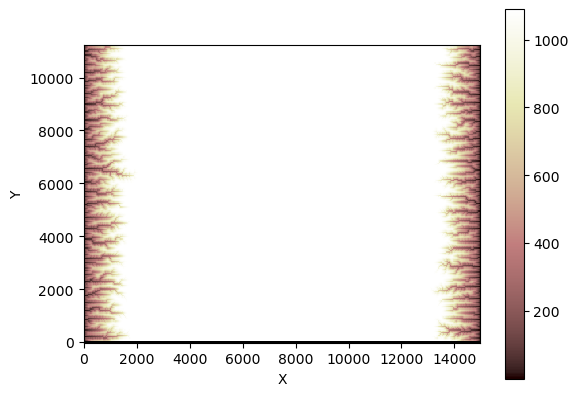

870


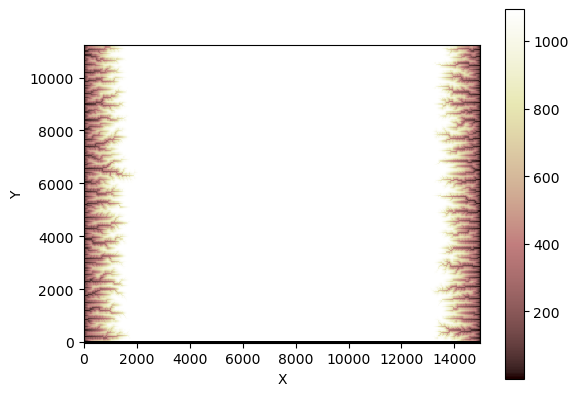

880


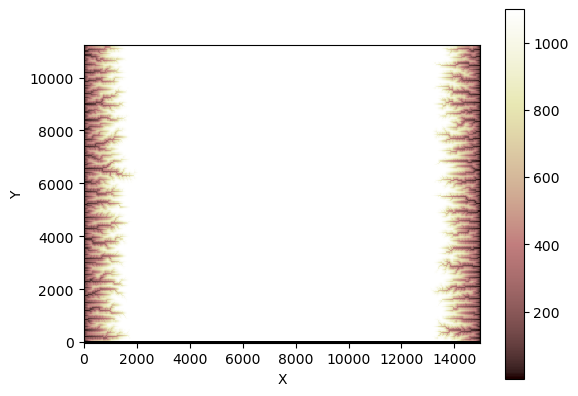

890


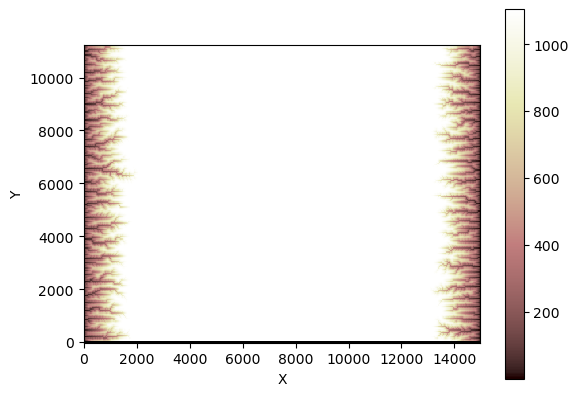

900


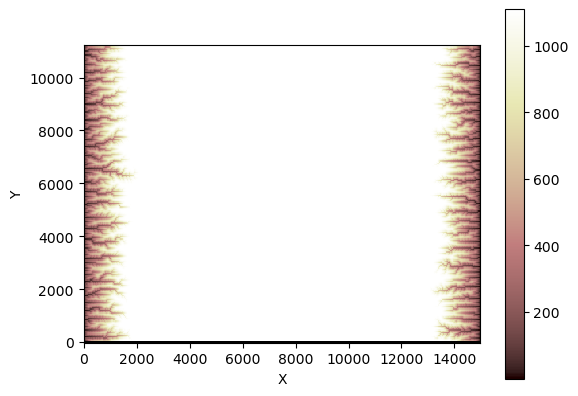

910


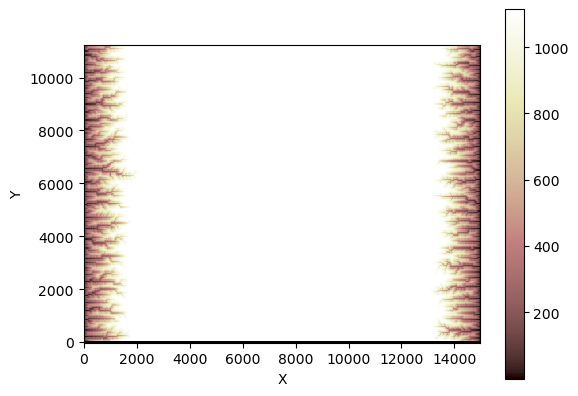

920


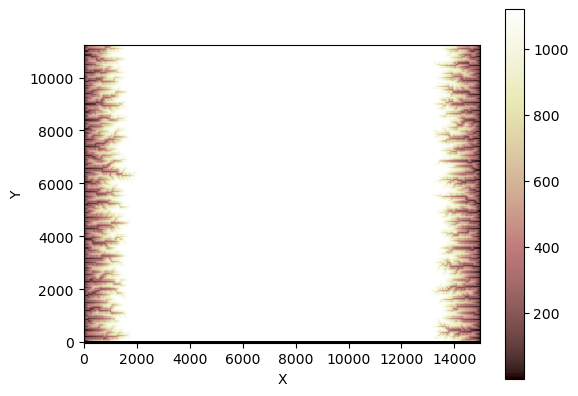

930


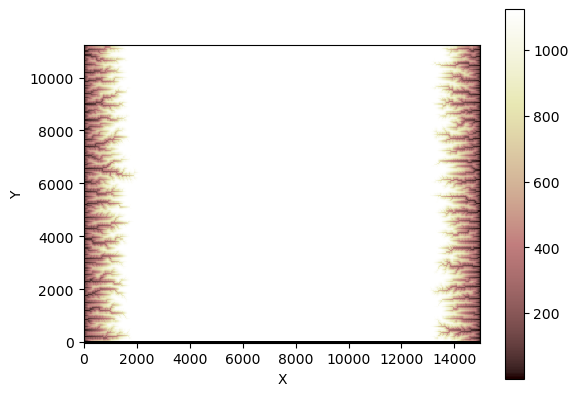

940


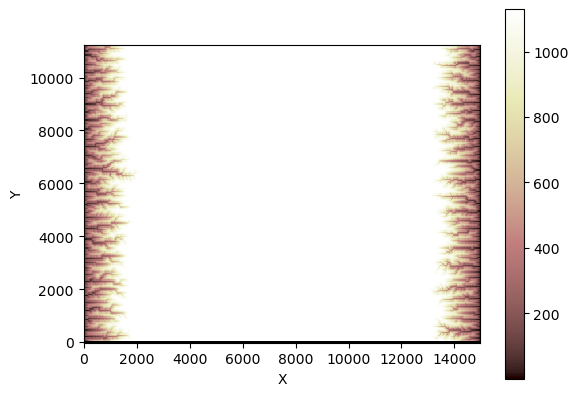

950


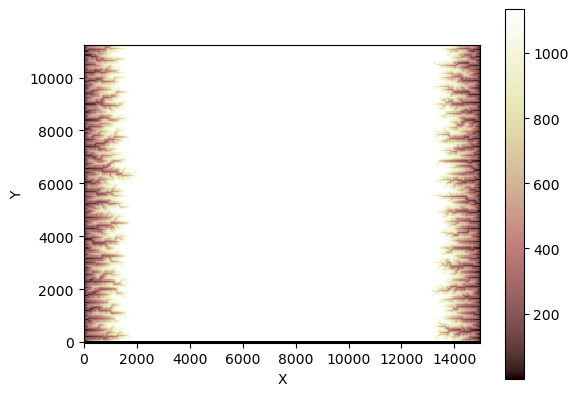

960


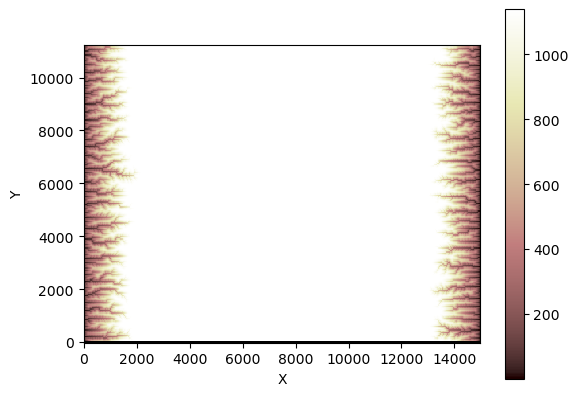

970


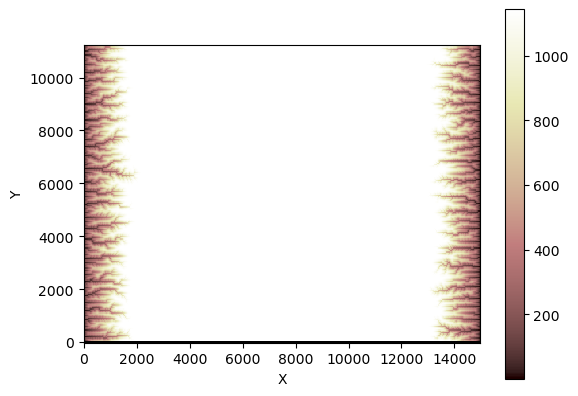

980


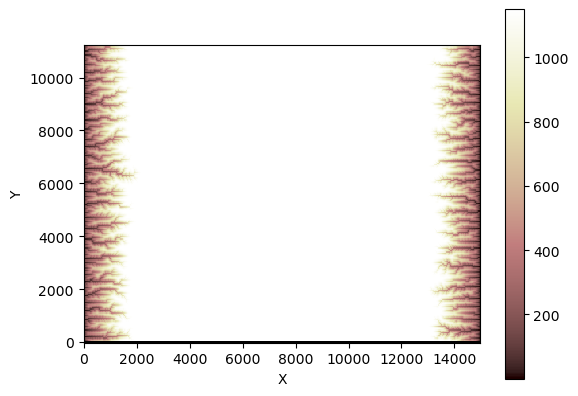

990


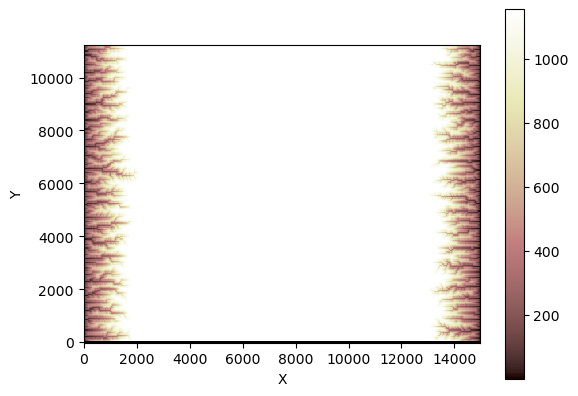

1000
Total computation time is 1.78 mins


In [26]:
start = time()  # For calculating computational runtime
for i in range(n_steps):

    basin_mg.at_node['topographic__elevation'][basin_mg.core_nodes] += uplift_per_steps[basin_mg.core_nodes]
    fa.run_one_step()
    sp.run_one_step(dt=dt)
    ld.run_one_step(dt)

    if i%10 == 0:
        imshow_grid(basin_mg, 'topographic__elevation')
        plt.show()
        print(i)
end = time()
print(f"Total computation time is {(end - start)/60:.2f} mins")

In [ ]:
## save the model 

### Setting up our fault from our steady-state model



In [ ]:
nf = NormalFault("faulted_surface": "topographic__elevation",
        ...     "fault_dip_angle": dip_mean,
        ...     "fault_throw_rate_through_time": {
        ...         "time": [0, 9, 10],
        ...         "rate": [0, 0, 0.05],
        ...     },)



In [ ]:
for i in range(n_steps):

    basin_mg.at_node['topographic__elevation'][basin_mg.core_nodes] += uplift_per_steps[basin_mg.core_nodes]
    fa.run_one_step()
    sp.run_one_step(dt=dt)
    ld.run_one_step(dt)
    nf.run_one_step(dt)

    if i%1000 == 0:
        imshow_grid(basin_mg, 'topographic__elevation')
        plt.show()
        print(i)

In [ ]:
##topographic analyses here

from landlab.components import (
    ChannelProfiler,
    ChiFinder,
    SteepnessFinder,
)

theta = m_sp / n_sp
# initialize the component that will calculate channel steepness
sf = SteepnessFinder(mg1, reference_concavity=theta, min_drainage_area=1000.0)
# initialize the component that will calculate the chi index
cf = ChiFinder(mg1,
               min_drainage_area=1000.0,
               reference_concavity=theta,
               use_true_dx=True)


## Below section on topographic analysis
1. Extract longitudinal profiles
2. Extract Chi information

Workflow:
For a given RasterModelGrid:
* Run ChannelProfiler
* Run ChiFinder
* Run plot_topographic_metrics function

In [27]:
# Imports
from landlab.components import ChiFinder
from landlab.components import ChannelProfiler
from matplotlib.collections import LineCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable

Generate a function to calculate the Courant-Friedrichs-Lewy condition. Our model timestep wants to be lower than this, to ensure numerical stability.

In [ ]:
# Extract rivers
cp = ChannelProfiler(grid, number_of_watersheds=5)
cp.run_one_step()

# Extract chi
cf = ChiFinder(basin_mg, min_drainage_area=1000.0, reference_concavity=0.5, clobber=True)
cf.calculate_chi()

In [28]:
def calculate_courant(A, dx=1e3, v=1e-6, m=0.5):
    """
    Calculates a timestep which satisfies the courant condition
    based on a user inputted area
    returns dt, yrs
    """
    dt = dx / (v * A ** m)
    return round(dt, 0)

In [31]:
# Max drainage area
max_A = np.max(basin_mg.at_node['drainage_area'])
print("Maximum drainage area is ", max_A, "m$^2$")
print("This is ", max_A/1e6, "km$^2$")

courant = calculate_courant(max_A, dx, K_sp, m_sp)
print("Max courant timestep is", courant, "yr")

Maximum drainage area is  2185500.0 m$^2$
This is  2.1855 km$^2$
Max courant timestep is 8421.0 yr


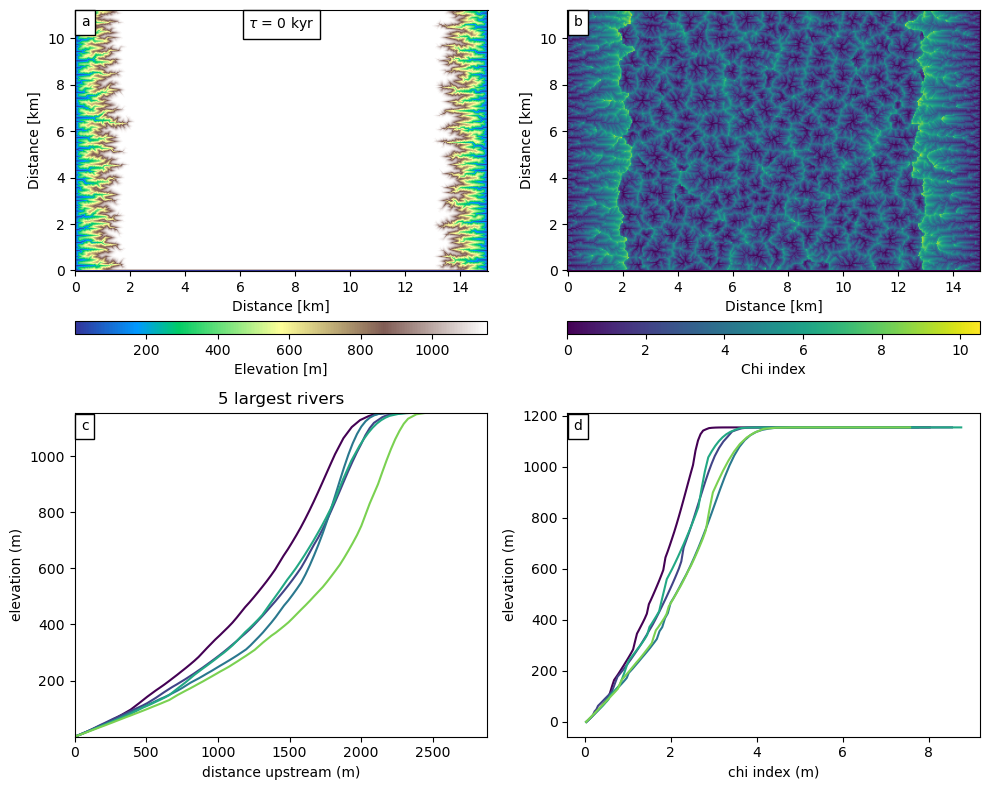

In [126]:
# Overall plotting

fig = plt.figure(figsize=(10, 8))
shp = (2, 2)
ax0 = plt.subplot2grid(shp, (0, 0), rowspan=1, colspan=1, aspect='auto')  # Topo with rivers
ax1 = plt.subplot2grid(shp, (0, 1), rowspan=1, colspan=1, aspect='auto')  # Chi map
ax2 = plt.subplot2grid(shp, (1, 0), rowspan=1, colspan=1, aspect='auto')  # Long profiles
ax3 = plt.subplot2grid(shp, (1, 1), rowspan=1, colspan=1, aspect='auto')  # chi values

# Colorbar axes
divider0 = make_axes_locatable(ax0)
cbar_ax0 = divider0.append_axes("bottom", size="5%", pad=0.5)
divider1 = make_axes_locatable(ax1)
cbar_ax1 = divider1.append_axes("bottom", size="5%", pad=0.5)

# Axes ticks and labels
xticks = np.array([0, 2000, 4000, 6000, 8000, 10000, 12000, 14000])/30
xlabels = [0, 2, 4, 6, 8, 10, 12, 14]
yticks = np.array([0, 2000, 4000, 6000, 8000, 10000])/50
ylabels = [0, 2, 4, 6, 8, 10]

# Plot topography with long profiles
im0 = ax0.imshow(basin_mg.at_node['topographic__elevation'].reshape(basin_mg.shape), aspect='auto', origin='lower', cmap='terrain')
ax0.set_xlabel('Distance [km]'), ax0.set_ylabel('Distance [km]')
ax0.set_xticks(xticks, xlabels)
ax0.set_yticks(yticks, ylabels)
# create segments the way that line collection likes them.
endpoints_only = False
segments = []
for nodes in profiler.nodes:
    if endpoints_only:
        select_nodes = [nodes[0], nodes[-1]]
        segments.append(
            list(
                zip(
                    basin_mg.x_of_node[select_nodes],
                    basin_mg.y_of_node[select_nodes],
                )
            )
        )

    else:
        segments.append(
            list(zip(basin_mg.x_of_node[nodes], basin_mg.y_of_node[nodes]))
        )

line_segments = LineCollection(segments)
colors = profiler.colors
line_segments.set_color(colors)
ax0.add_collection(line_segments)
# Add text
ax0.text(0.5, 0.98, f'$\\tau$ = 0 kyr', transform=ax0.transAxes, ha='center', va='top', bbox=dict(fc='w'))
ax0.text(0.015, 0.98, 'a', transform=ax0.transAxes, ha='left', va='top', bbox=dict(fc='w'))
plt.colorbar(im0, cax=cbar_ax0, orientation='horizontal', label='Elevation [m]')

# Plot chi map
im1 = ax1.imshow(basin_mg.at_node['channel__chi_index'].reshape(basin_mg.shape), aspect='auto', origin='lower', cmap='viridis')
ax1.set_xlabel('Distance [km]'), ax1.set_ylabel('Distance [km]')
ax1.set_xticks(xticks, xlabels)
ax1.set_yticks(yticks, ylabels)
ax1.text(0.015, 0.98, 'b', transform=ax1.transAxes, ha='left', va='top', bbox=dict(fc='w'))
plt.colorbar(im1, cax=cbar_ax1, label='Chi index', orientation='horizontal')

# Plot long profiles
plt.subplot(223)
profiler.plot_profiles(xlabel='distance upstream (m)',
                  ylabel='elevation (m)', title='5 largest rivers')
ax2.text(0.015, 0.98, 'c', transform=ax2.transAxes, ha='left', va='top', bbox=dict(fc='w'))

# Plot chi profiles
plt.subplot(224)
for i, outlet_id in enumerate(profiler.data_structure):
    for j, segment_id in enumerate(profiler.data_structure[outlet_id]):
        if j == 0:
            label = f"channel {i + 1}"
        else:
            label = "_nolegend_"
        segment = profiler.data_structure[outlet_id][segment_id]
        profile_ids = segment["ids"]
        color = segment["color"]
        plt.plot(
            basin_mg.at_node["channel__chi_index"][profile_ids],
            basin_mg.at_node["topographic__elevation"][profile_ids],
            color=color,
            label=label,
        )

ax3.set_xlabel("chi index (m)")
ax3.set_ylabel("elevation (m)")
ax3.text(0.015, 0.98, 'd', transform=ax3.transAxes, ha='left', va='top', bbox=dict(fc='w'))

plt.tight_layout()
plt.show()

In [127]:
# Turn into a function
def plot_topographic_metrics(grid_, channel_profiler_, time_, save=False):
    """ Produce a four-panel plot of topographic metrics for a landscape.
    (a) Elevation map
    (b) Chi map
    (c) Longitudinal profiles
    (d) Chi profiles

    Parameters:
    -----------------
    grid_: Landlab RasterModelGrid
    channel_profiler_: Landlab ChannelProfiler object
    time_: Age of the landscape in kyr
    save: Save the resulting figure as png. Default is false

    Returns figure.
    """
    
    # Instantiate figure
    fig = plt.figure(figsize=(10, 8))
    shp = (2, 2)
    ax0 = plt.subplot2grid(shp, (0, 0), rowspan=1, colspan=1, aspect='auto')  # Topo with rivers
    ax1 = plt.subplot2grid(shp, (0, 1), rowspan=1, colspan=1, aspect='auto')  # Chi map
    ax2 = plt.subplot2grid(shp, (1, 0), rowspan=1, colspan=1, aspect='auto')  # Long profiles
    ax3 = plt.subplot2grid(shp, (1, 1), rowspan=1, colspan=1, aspect='auto')  # chi values

    # Colorbar axes
    divider0 = make_axes_locatable(ax0)
    cbar_ax0 = divider0.append_axes("bottom", size="5%", pad=0.5)
    divider1 = make_axes_locatable(ax1)
    cbar_ax1 = divider1.append_axes("bottom", size="5%", pad=0.5)
    
    # Axes ticks and labels
    xticks = np.array([0, 2000, 4000, 6000, 8000, 10000, 12000, 14000])/grid_.dx
    xlabels = [0, 2, 4, 6, 8, 10, 12, 14]
    yticks = np.array([0, 2000, 4000, 6000, 8000, 10000])/grid_.dy
    ylabels = [0, 2, 4, 6, 8, 10]
    
    # Plot topography with long profiles
    im0 = ax0.imshow(grid_.at_node['topographic__elevation'].reshape(grid_.shape), aspect='auto', origin='lower', cmap='terrain')
    ax0.set_xlabel('Distance [km]'), ax0.set_ylabel('Distance [km]')
    ax0.set_xticks(xticks, xlabels)
    ax0.set_yticks(yticks, ylabels)
    # create segments the way that line collection likes them.
    endpoints_only = False
    segments = []
    for nodes in channel_profiler_.nodes:
        if endpoints_only:
            select_nodes = [nodes[0], nodes[-1]]
            segments.append(
                list(
                    zip(
                        grid_.x_of_node[select_nodes],
                        grid_.y_of_node[select_nodes],
                    )
                )
            )
    
        else:
            segments.append(
                list(zip(grid_.x_of_node[nodes], grid_.y_of_node[nodes]))
            )
    
    line_segments = LineCollection(segments)
    colors = channel_profiler_.colors
    line_segments.set_color(colors)
    ax0.add_collection(line_segments)
    # Add text
    ax0.text(0.5, 0.98, f'$\\tau$ = {time_} kyr', transform=ax0.transAxes, ha='center', va='top', bbox=dict(fc='w'))
    ax0.text(0.015, 0.98, 'a', transform=ax0.transAxes, ha='left', va='top', bbox=dict(fc='w'))
    plt.colorbar(im0, cax=cbar_ax0, orientation='horizontal', label='Elevation [m]')
    
    # Plot chi map
    im1 = ax1.imshow(grid_.at_node['channel__chi_index'].reshape(grid_.shape), aspect='auto', origin='lower', cmap='viridis')
    ax1.set_xlabel('Distance [km]'), ax1.set_ylabel('Distance [km]')
    ax1.set_xticks(xticks, xlabels)
    ax1.set_yticks(yticks, ylabels)
    ax1.text(0.015, 0.98, 'b', transform=ax1.transAxes, ha='left', va='top', bbox=dict(fc='w'))
    plt.colorbar(im1, cax=cbar_ax1, label='Chi index', orientation='horizontal')
    
    # Plot long profiles
    plt.subplot(223)
    channel_profiler_.plot_profiles(xlabel='Upstream Distance [m]',
                      ylabel='Elevation [m]', title='Longitudinal Profiles')
    ax2.text(0.015, 0.98, 'c', transform=ax2.transAxes, ha='left', va='top', bbox=dict(fc='w'))
    
    # Plot chi profiles
    plt.subplot(224)
    for i, outlet_id in enumerate(channel_profiler_.data_structure):
        for j, segment_id in enumerate(channel_profiler_.data_structure[outlet_id]):
            if j == 0:
                label = f"channel {i + 1}"
            else:
                label = "_nolegend_"
            segment = channel_profiler_.data_structure[outlet_id][segment_id]
            profile_ids = segment["ids"]
            color = segment["color"]
            plt.plot(
                grid_.at_node["channel__chi_index"][profile_ids],
                grid_.at_node["topographic__elevation"][profile_ids],
                color=color,
                label=label,
            )
    
    ax3.set_xlabel("Chi Index [m]")
    ax3.set_ylabel("Elevation [m]")
    ax3.text(0.015, 0.98, 'd', transform=ax3.transAxes, ha='left', va='top', bbox=dict(fc='w'))
    
    plt.tight_layout()

    if save:
        plt.savefig('synthetic_results_' + time_ +'.png', dpi=300)

    return None

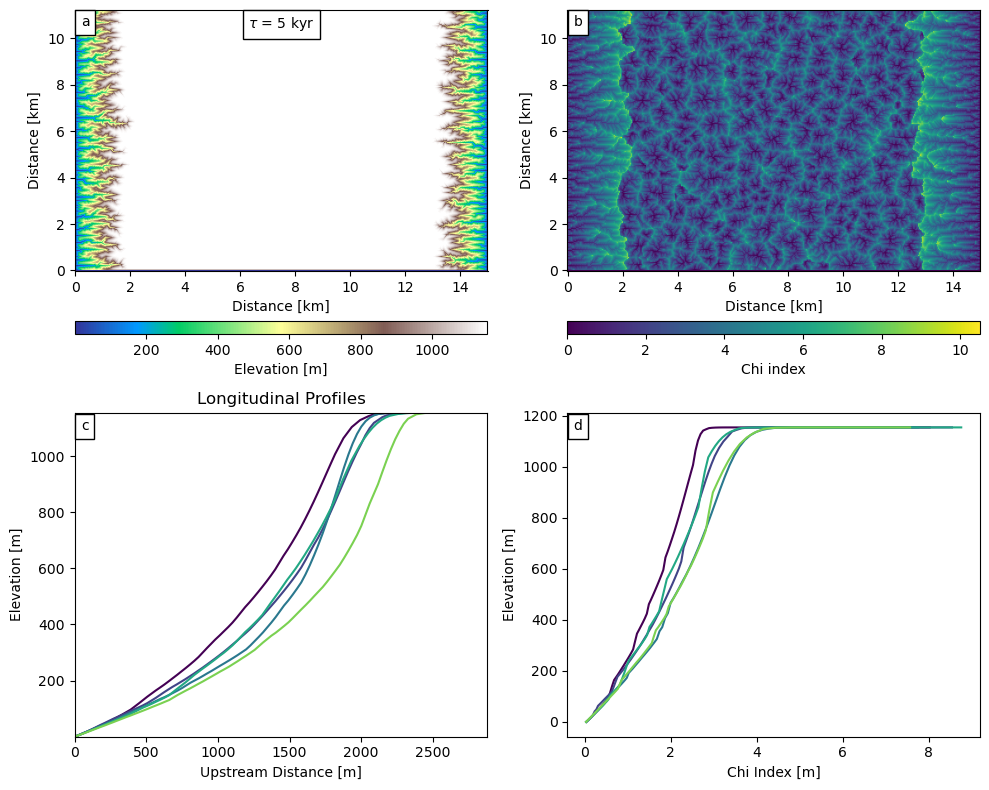

In [135]:
plot_topographic_metrics(basin_mg, profiler, 5)